Constructing tranmission matrix and distributed reproduction number from real-world contact network
Data source: from the paper High-Resolution Measurements of Face-to-Face Contact Patterns in a Primary School (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0023176)
The data we use is the Cumulative contact network for day 1, in gml format; each edge is weighted by the total time in face-to-face proximity (“duration”) and the number of events of face-to-face proximity (“count”) detected between the two corresponding RFID badges.

The paper also provides Cumulative contact network for day 2, in gml format; each edge is weighted by the total time in face-to-face proximity (“duration”) and the number of events of face-to-face proximity (“count”) detected between the two corresponding RFID badges.

The paper also list of tags and corresponding class of the person who wore it (for clustering analysis)

In [2]:
#Constructing a transmission network
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors

import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))

In [3]:
# Read the .gml file: cumulative contact network for day 1 
Contact_Network_Day_1 = nx.read_gml('../data/Transmission_Matrix_1.gml', label = 'id')
print (Contact_Network_Day_1)

Graph with 238 nodes and 5539 edges


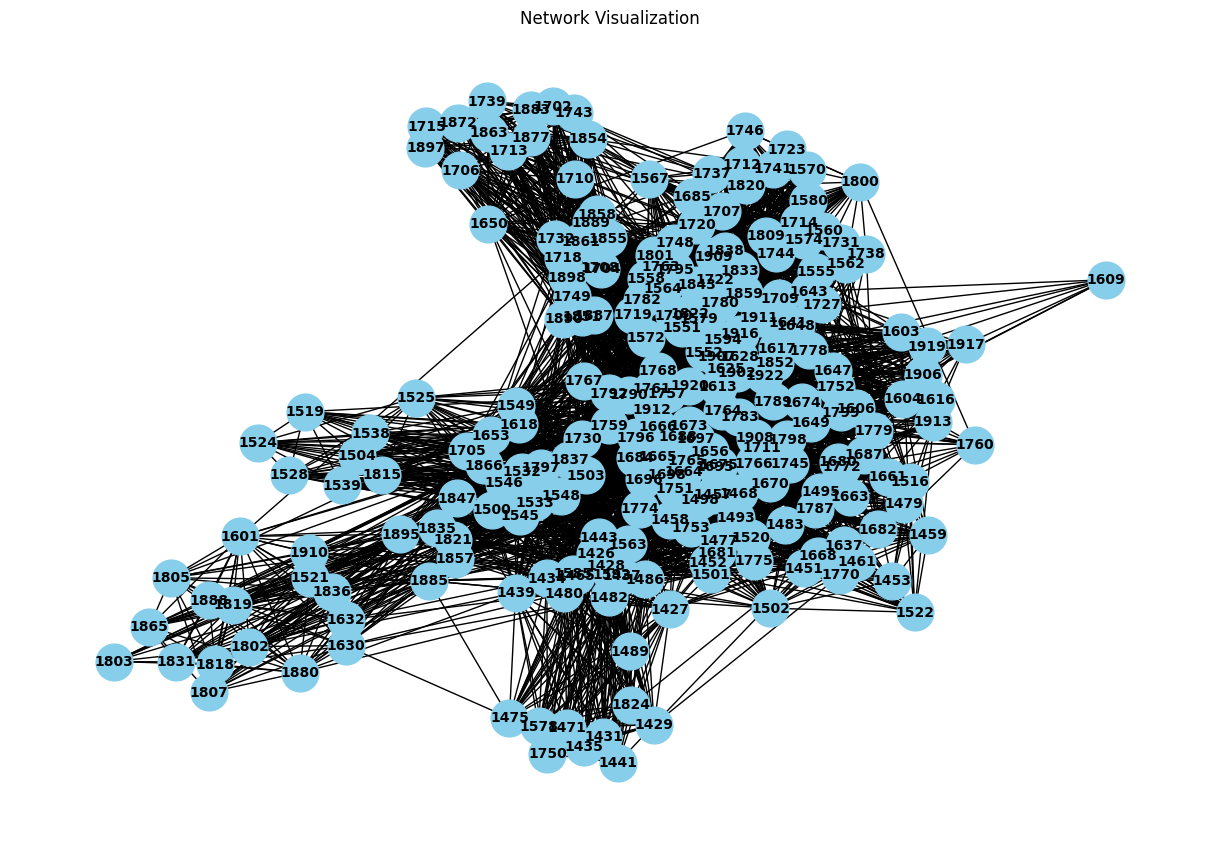

In [4]:
# Visualize the contact network-topology only
plt.figure(figsize=(12, 8))
nx.draw(Contact_Network_Day_1, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")
plt.title('Network Visualization')
plt.show()

Each edge in the dataset has two attributes: counts and duration. Counts indicate the total number of times these two individuals interact during the day. Duration indicates how long the two individuals interact, measured in seconds. We consider the tranmission rate is proportional to the attribute "duration". Hence, we use the attribute "duration" to construct our contact matrix first.

In [5]:
# Extract the values of the specific attribute (e.g., 'weight')
attribute_values = [data['duration'] for u, v, data in Contact_Network_Day_1.edges(data=True) if 'duration' in data]

In [6]:
# Calculate the range of the attribute values
if attribute_values:
    min_value = min(attribute_values)
    max_value = max(attribute_values)
    print(f"The range of the 'duration' attribute is from {min_value} to {max_value}.")
else:
    print("The attribute 'duration' is not found in any edges.")

The range of the 'duration' attribute is from 20 to 8840.


In [7]:
#Assigning the attribute as edge weights
for u, v, data in Contact_Network_Day_1.edges(data=True):
    if 'duration' in data:
        data['weight'] = data['duration']

In [8]:
# Remove edges with weights lower than 200
edges_to_remove = [(u, v) for u, v, data in Contact_Network_Day_1.edges(data=True) if data.get('weight', 0) < 200]
Contact_Network_Day_1.remove_edges_from(edges_to_remove)
# Remove nodes with no edges
nodes_to_remove = [node for node in Contact_Network_Day_1.nodes() if Contact_Network_Day_1.degree(node) == 0]
Contact_Network_Day_1.remove_nodes_from(nodes_to_remove)

In [9]:
# Generate the weighted adjacency matrix - contact matrix
contact_matrix = nx.to_numpy_array(Contact_Network_Day_1, weight='weight')
contact_matrix

array([[   0.,    0.,    0., ...,    0.,  300.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,  320.,    0.,    0.],
       ...,
       [   0.,    0.,  320., ...,    0.,    0.,    0.],
       [ 300.,    0.,    0., ...,    0.,    0., 1080.],
       [   0.,    0.,    0., ...,    0., 1080.,    0.]])

Plot the contact network. Node size scales with respect to its degree. Edge width scales with respect to the edge weights, i.e., contact duration.

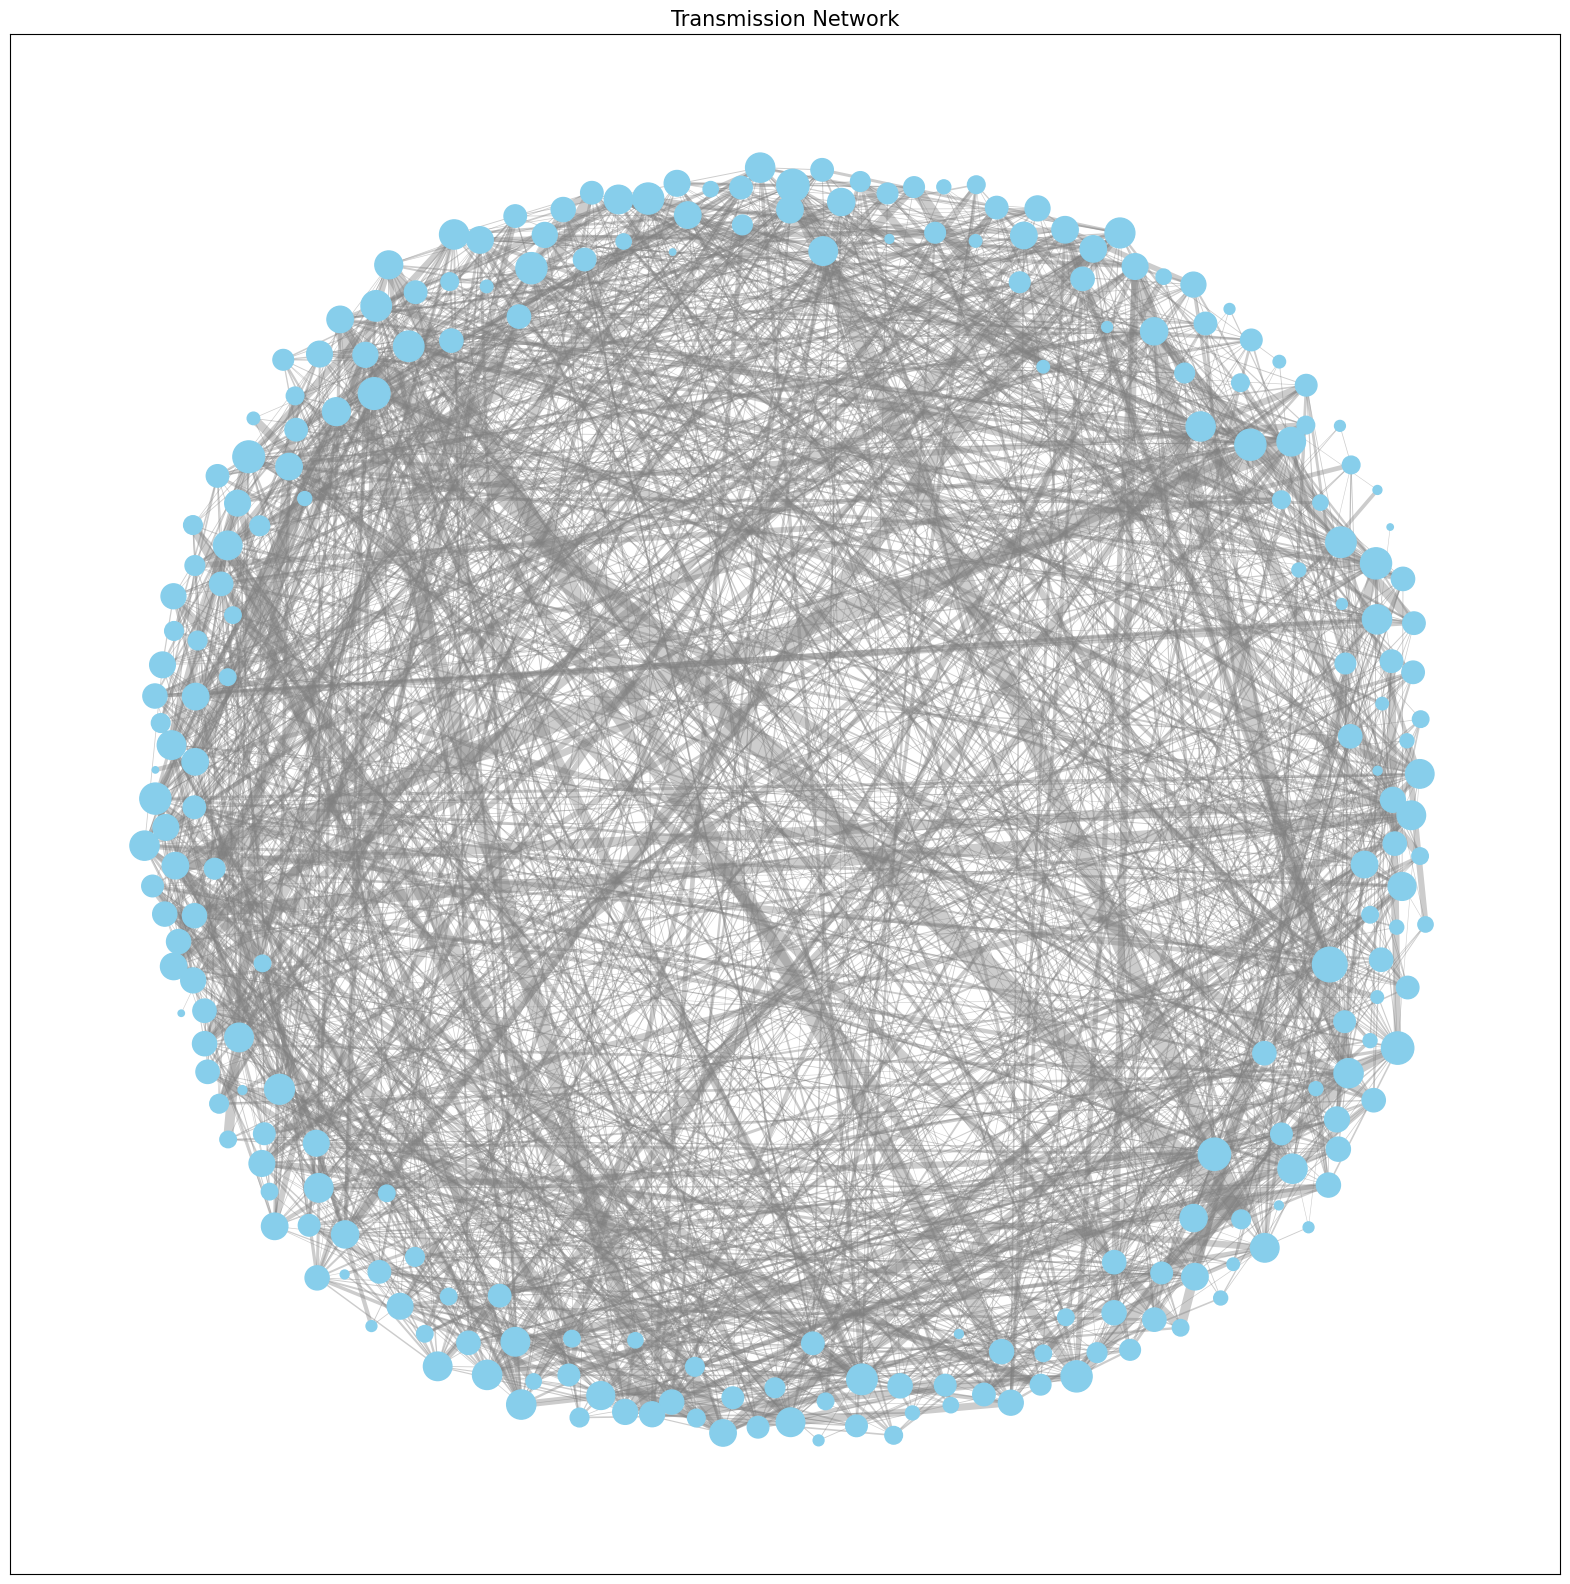

In [10]:
# Plot the contact network
plt.figure(figsize=(20, 20))

# Use spring layout to avoid overlaps
pos = nx.spring_layout(Contact_Network_Day_1, k=100, iterations=50)

# Node sizes scaled with degree
node_sizes = [1 + 20 * nx.degree(Contact_Network_Day_1, node) for node in Contact_Network_Day_1.nodes()]

# Edge widths scaled with weight
edge_weights = [Contact_Network_Day_1[u][v]['weight'] / 500.0 for u, v in Contact_Network_Day_1.edges()]

# Draw nodes
nx.draw_networkx_nodes(Contact_Network_Day_1, pos, node_size=node_sizes, node_color="skyblue", alpha=1)

# Draw edges
nx.draw_networkx_edges(Contact_Network_Day_1, pos, width=edge_weights, edge_color='grey', alpha=0.4)

plt.title('Transmission Network', fontsize=15)
plt.show()

In [11]:
# The reproduction number  (Ref: Estimates of the reproduction number for seasonal, pandemic, and zoonotic influenza: a systematic review of the literature)
# A median reproduction number of 1.22 (Global variation in early epidemic growth rates and reproduction number of seasonal influenza, 2022)
# Define the reproduction number
Repro_Num_Flu = 5.67

In [12]:
# Uncomplicated influenza signs and symptoms typically resolve after 3-7 days for the majority of people, although cough and malaise can persist for >2 weeks, especially in elderly people and those with chronic lung disease. 
# ref: https://www.cdc.gov/flu/professionals/acip/clinical.htm#:~:text=Uncomplicated%20influenza%20signs%20and%20symptoms,those%20with%20chronic%20lung%20disease.
# Define recovery matrix
# homogeneous recovery rate (4-day recovery)
hom_rec_days = 4
hom_rec_rate = 1/hom_rec_days

In [13]:
# Define the diagonal recovery matrix, where the dimension is the same as the contact_matrix. Rec_matrix = recovery rate * I_n
n = contact_matrix.shape[0]
Rec_matrix_inv = hom_rec_days * np.eye(n)

compute the initial product matrix (reproduction number matrix $\Gamma^{-1}B$)
We have the contact matrix. we want to obtain the transmission matrix by scaling the contact matrix. 
In order to obtain the transmission matrix, we use the following method. We consider influenza spreading over the contact network. Typical reproduction number of influenza is in the range of 1.1-1.3 (A median reproduction number of 1.22 (Global variation in early epidemic growth rates and reproduction number of seasonal influenza, 2022)). Hence, $spectra_radius(\Gamma^{-1}B) = Reproduction number = 1.22$. We consider homogeneous recovery rate for all individuals, such that the everyone takes 4 days to recover (https://www.cdc.gov/flu/professionals/acip/clinical.htm#:~:text=Uncomplicated%20influenza%20signs%20and%20symptoms,those%20with%20chronic%20lung%20disease.). Therefore, recovery rate = 1/4, and the diagonal recovery matrix $[\Gamma]_{ii}=1/4$. 
We consider the transmission matrix  $B = \beta * contact matrix$, where $\beta$ is our scaling factor.
We have the condition that $spectra_radius(\Gamma^{-1}B) =  spectra_radius(\Gamma^{-1}*\beta * contact matrix) = Reproduction number = 1.22$.
We can obtain $\beta$, thus, the transmission matrix.


In [14]:
#from util.notebook_util import spectral_radius, binary_search_beta
# Start with an initial guess for beta
#beta = 7.90e-5 # You can choose any positive value

# Iteratively adjust beta to meet the condition
#for _ in range(10):  # Adjust iterations as needed
#    product_matrix =  beta * Rec_matrix_inv @ contact_matrix
#    radius = spectral_radius(product_matrix)
    
#    if radius < Repro_Num_Flu:
#        beta += 1e-7 # Increase beta
#    else:
#        beta -= 1e-7  # Decrease beta
# Final beta
#print(f"Computed scalar beta: {beta}")

In [15]:
from util.notebook_util import spectral_radius, binary_search_beta
beta_start = 1.90e-5
beta_end = 8e-4

# binary search for beta
beta = binary_search_beta(start = beta_start, 
                          end = beta_end, 
                          target = Repro_Num_Flu, 
                          Rec_matrix_inv = Rec_matrix_inv, 
                          contact_matrix = contact_matrix)

print(f"The final value of reproduction number is: {spectral_radius(beta * Rec_matrix_inv @ contact_matrix)}.")
print(f"The final value of beta is: {beta}.")

The final value of reproduction number is: 5.67.
The final value of beta is: 8.088465351285251e-05.


In [16]:
# The transmission matrix is given by
transmission_matrix = contact_matrix * beta

# The reproduction number matrix is given by
reproduction_number_matrix =  beta * Rec_matrix_inv @ contact_matrix
reproduction_number_matrix.shape

(237, 237)

In [17]:
# save reproduction matrix to csv file
import pandas as pd

df = pd.DataFrame(reproduction_number_matrix)
df.to_csv('../data/reproduction_number_matrix.csv',index=False, header=False)